In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
print(tf.__version__, 'tf')
print(keras.__version__, 'keras')

2.3.0 tf
2.4.0 keras


In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 3s 0us/step


In [4]:
print(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

/root/.keras/datasets/flower_photos
3670


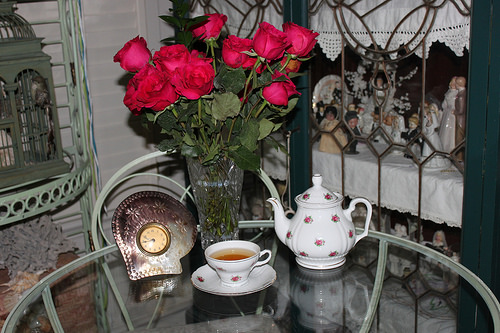

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

In [38]:
batch_size = 128
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

AttributeError: module 'tensorflow._api.v2.data' has no attribute 'AUTOTUNE'

In [14]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [15]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 17s 189ms/step - loss: 1.3083 - accuracy: 0.4414 - val_loss: 1.1107 - val_accuracy: 0.5518
Epoch 2/10
92/92 [==============================] - 11s 118ms/step - loss: 0.9884 - accuracy: 0.6121 - val_loss: 0.9748 - val_accuracy: 0.5845
Epoch 3/10
92/92 [==============================] - 10s 112ms/step - loss: 0.8221 - accuracy: 0.6907 - val_loss: 0.9105 - val_accuracy: 0.6431
Epoch 4/10
92/92 [==============================] - 10s 107ms/step - loss: 0.6204 - accuracy: 0.7653 - val_loss: 0.9460 - val_accuracy: 0.6526
Epoch 5/10
92/92 [==============================] - 10s 107ms/step - loss: 0.4341 - accuracy: 0.8413 - val_loss: 1.0285 - val_accuracy: 0.6362
Epoch 6/10
92/92 [==============================] - 10s 110ms/step - loss: 0.2464 - accuracy: 0.9131 - val_loss: 1.2983 - val_accuracy: 0.6362
Epoch 7/10
92/92 [==============================] - 10s 107ms/step - loss: 0.1651 - accuracy: 0.9479 - val_loss: 1.3462 - val_accuracy: 0.6240

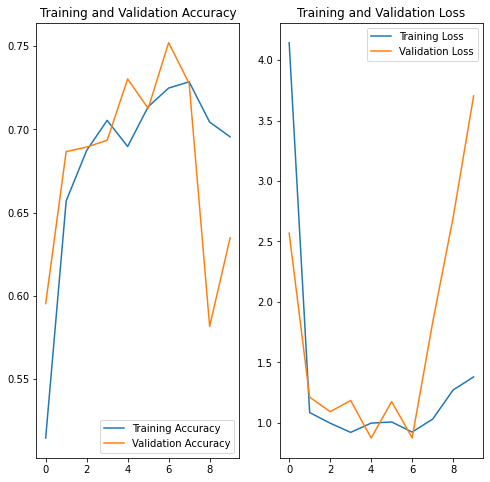

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [40]:
from keras.applications.vgg16 import VGG16

vgg16_model1 = VGG16(include_top=False, weights='imagenet', input_shape=(180,180, 3))
vgg16_model1.trainable = False

In [41]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [42]:
from keras.layers import Dense, Concatenate, Input, Lambda, Flatten, Softmax, BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.layers.advanced_activations import LeakyReLU

input_matrix = Input(shape=(180,180,3))   # 6

branch_outputs = []

# loop for however many branches you want to use.  (each branch needs 3 channel depth)
for i in [0]:
    # create looping so that vgg16 model input is created ie 256,256,3
    print(input_matrix.shape)
    out = Lambda(lambda x: x[:,:,:,i:i+3])(input_matrix)
    out = data_augmentation(out)
    out = layers.experimental.preprocessing.Rescaling(1./255)(out)

    print(out.shape)
    
    # Setting up your layers in each branch: (currently each branch is identical architecture.)
    if i == 0: out = Sequential(vgg16_model1)(out)   # use pretrained and loaded vgg16
    elif i == 3: out = Sequential(vgg16_model2)(out)
    else: out = Sequential(vgg16_model3)(out)   # use pretrained and loaded vgg16
    print(out.shape)
#    branch_outputs.append(out)
#mergedOut = Concatenate()(branch_outputs)
mergedOut = out
print(mergedOut.shape)
mergedOut = Dense(512, activation=LeakyReLU(alpha = 0.1))(mergedOut)
mergedOut = LeakyReLU(alpha = 0.4)(mergedOut)
mergedOut = Dropout(.5)(mergedOut)
mergedOut = BatchNormalization()(mergedOut)

mergedOut = Dense(256, activation=LeakyReLU(alpha = 0.1))(mergedOut)
mergedOut = LeakyReLU(alpha = 0.1)(mergedOut)
mergedOut = Dropout(.1)(mergedOut)
mergedOut = BatchNormalization()(mergedOut)

mergedOut = Dense(128, activation=LeakyReLU(alpha = 0.1))(mergedOut)
mergedOut = LeakyReLU(alpha = 0.1)(mergedOut)
mergedOut = Dropout(.1)(mergedOut)
mergedOut = BatchNormalization()(mergedOut)

mergedOut = Flatten()(mergedOut)
mergedOut = Dense(5)(mergedOut)

rgb_model_vgg16 = Model(inputs=input_matrix, outputs=mergedOut)   


opt = keras.optimizers.Adam(learning_rate=0.05)

rgb_model_vgg16.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

rgb_model_vgg16.summary()

(None, 180, 180, 3)
(None, 180, 180, 3)
(None, 5, 5, 512)
(None, 5, 5, 512)
Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 180, 180, 3)]     0         
_________________________________________________________________
lambda_8 (Lambda)            (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_10 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_11 (Sequential)   (None, 5, 5, 512)         14714688  
_________________________________________________________________
dense_34 (Dense)             (None, 5, 5, 512)         262656    
___________________________________________

In [43]:
epochs=10
history = rgb_model_vgg16.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
23/23 [==============================] - 47s 2s/step - loss: 5.5508 - accuracy: 0.5099 - val_loss: 189.5610 - val_accuracy: 0.4469
Epoch 2/10
23/23 [==============================] - 23s 1s/step - loss: 1.3989 - accuracy: 0.6267 - val_loss: 3.6640 - val_accuracy: 0.6512
Epoch 3/10
23/23 [==============================] - 23s 991ms/step - loss: 0.9254 - accuracy: 0.6965 - val_loss: 1.6401 - val_accuracy: 0.6703
Epoch 4/10
23/23 [==============================] - 23s 1s/step - loss: 0.7051 - accuracy: 0.7527 - val_loss: 1.0539 - val_accuracy: 0.7193
Epoch 5/10
23/23 [==============================] - 23s 995ms/step - loss: 0.6936 - accuracy: 0.7670 - val_loss: 1.0323 - val_accuracy: 0.7684
Epoch 6/10
23/23 [==============================] - 23s 996ms/step - loss: 0.5743 - accuracy: 0.7987 - val_loss: 1.1196 - val_accuracy: 0.6975
Epoch 7/10
23/23 [==============================] - 23s 996ms/step - loss: 0.5920 - accuracy: 0.7929 - val_loss: 0.6134 - val_accuracy: 0.8025
Epoch 

In [47]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = rgb_model_vgg16.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 99.85 percent confidence.
